In [1]:
%run model.ipynb

Using TensorFlow backend.
model.ipynb:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "metadata": {},
model.ipynb:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
  "import pandas as pd\n",


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
import sys
sys.path.append('../preparations/')

In [3]:
import x01_generate_notes
import x02_generate_midi
import x03_generate_wav
import x04_generate_wav_processed
import x05_generate_spectrogram
import x06_generate_label

In [4]:
!mkdir notes
!mkdir midi
!mkdir wav
!mkdir wav_processed
!mkdir spectrogram
!mkdir label
!rm ./notes/*
!rm ./midi/*
!rm ./wav/*
!rm ./wav_processed/*
!rm ./spectrogram/*
!rm ./label/*

mkdir: cannot create directory ‘notes’: File exists
mkdir: cannot create directory ‘midi’: File exists
mkdir: cannot create directory ‘wav’: File exists
mkdir: cannot create directory ‘wav_processed’: File exists
mkdir: cannot create directory ‘spectrogram’: File exists
mkdir: cannot create directory ‘label’: File exists
rm: cannot remove './notes/*': No such file or directory
rm: cannot remove './midi/*': No such file or directory
rm: cannot remove './wav/*': No such file or directory
rm: cannot remove './wav_processed/*': No such file or directory
rm: cannot remove './label/*': No such file or directory


In [5]:
import numpy as np
import random

def generate_note_file():
    sound_id = ''.join(random.choice('0123456789ABCDEF') for i in range(16))
    
    t = 0
    note_time_array = []
    
    while t < 20:
        t += 1.0 + np.random.uniform(1.0)
        
        notes_in_this_chord = []
        
        if np.random.uniform() > 0.2:
            new_note = np.random.randint(24)
            if new_note not in notes_in_this_chord:
                note_time_array.append([t, new_note])
                notes_in_this_chord.append(new_note)
                
        if np.random.uniform() > 0.2:
            new_note = np.random.randint(24)
            if new_note not in notes_in_this_chord:
                note_time_array.append([t, new_note])
                notes_in_this_chord.append(new_note)
            
        if np.random.uniform() > 0.2:
            new_note = np.random.randint(24)
            if new_note not in notes_in_this_chord:
                note_time_array.append([t, new_note])
                notes_in_this_chord.append(new_note)
        
        if np.random.uniform() > 0.2 or (t > 18 and t < 20):
            new_note = np.random.randint(24)
            if new_note not in notes_in_this_chord:
                note_time_array.append([t, new_note])
                notes_in_this_chord.append(new_note)
                
#     print(note_time_array)
    np.save("./notes/" + sound_id, note_time_array)

In [6]:
generate_note_file()

In [7]:
import glob

notes = glob.glob("./notes/*.npy")
print(len(notes))

for filename in notes:
    sound_id = filename[-20:-4]
    time_note_array = np.load(filename)
    time_array, note_array = np.transpose(time_note_array)
    x02_generate_midi.generate_midi_file(sound_id, time_array, np.array(note_array, dtype=int))

1


In [8]:
import glob

notes = glob.glob("./midi/*")
print(len(notes))
for filename in notes:
    x03_generate_wav.convert_midi_to_signal(filename)

1


In [14]:
files = glob.glob('./wav/*')
save_location = './wav_processed/'
print(len(files))
for filename in files:
    x04_generate_wav_processed.process_wav(filename, save_location)

1


In [15]:
import glob
files = glob.glob('./wav_processed/*')
print(len(files))
for filename in files:
    x05_generate_spectrogram.generate_spectrogram(filename)

1


In [16]:
# import glob
# files = glob.glob('../*.wav')
# print(len(files))
# for filename in files:
#     x05_generate_spectrogram.generate_spectrogram(filename)

In [17]:
import soundfile as sf
import sounddevice as sd

audio, sr = sf.read(files[0])

sd.play(audio, samplerate=sr)

In [18]:
import glob

notes = glob.glob("./notes/*.npy")
print(len(notes))

for filename in notes:
#     sound_id = filename[-20:-4]
#     time_note_array = np.load(filename)
#     time_array, note_array = np.transpose(time_note_array)
    x06_generate_label.generate_label(filename)

1


In [19]:
!ls ./notes/
!ls ./midi/
!ls ./wav/
!ls ./wav_processed/
!ls ./spectrogram/
!ls ./label/

31D386862A849137.npy
31D386862A849137.mid
31D386862A849137.wav
31D386862A849137.wav
31D386862A849137.npy
31D386862A849137.npy


In [20]:
import glob
import matplotlib.pyplot as plt

glob_label = glob.glob('./label/*')
glob_spectrogram = glob.glob('./spectrogram/*')
glob_notes = glob.glob('./notes/*.npy')

./notes/31D386862A849137.npy ./label/31D386862A849137.npy ./spectrogram/31D386862A849137.npy
(30, 2)


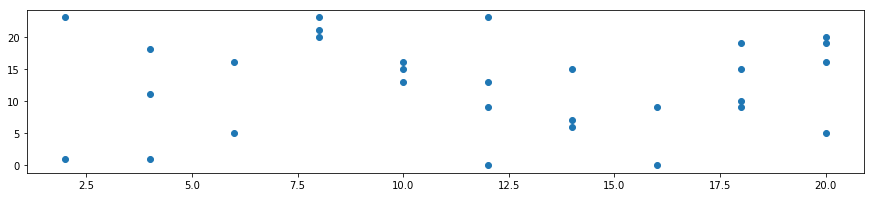

(140, 24)


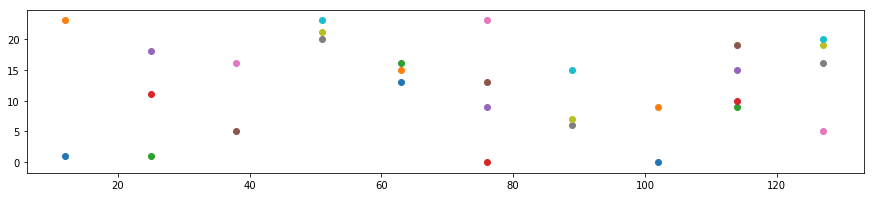

In [21]:
for notes_, label_, spectrogram_ in zip(glob_notes, glob_label, glob_spectrogram):
    print(notes_, label_, spectrogram_)
    
    notes = np.load(notes_)
    label = np.load(label_)
    spectrogram = np.load(spectrogram_)
    
    
    print(np.shape(notes))
    plt.figure(figsize=(15,3))
    plt.scatter(notes[:,0],notes[:,1])
    plt.show()
    
    
    print(np.shape(label))
    plt.figure(figsize=(15,3))
    for i,time_slice in enumerate(label):
        for j,note in enumerate(time_slice):
            if note != 0:
                plt.scatter(i,j)
    plt.show()
    

(108, 4221)
(108, 4221)
(108, 1, 108, 153)
(153, 1, 108, 108)
(1, 108, 108)


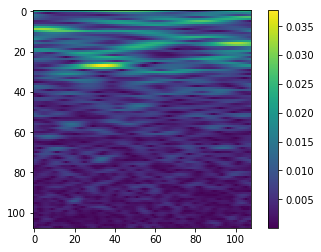

In [22]:
for notes_, label_, spectrogram_ in zip(glob_notes, glob_label, glob_spectrogram):
    print(np.shape(spectrogram))
    print(np.shape(spectrogram[:,:]))
    cnn_inputs = np.array(list(zip([spectrogram[:,i:-108+i:27] for i in range(108)])))
    print(np.shape(cnn_inputs))
    cnn_inputs = np.swapaxes(cnn_inputs,0,3)
    print(np.shape(cnn_inputs))
    cnn_inputs = [cnn_input for cnn_input in cnn_inputs]
    print(np.shape(cnn_inputs[1]))
    plt.imshow(cnn_inputs[7][0,:,:])
    plt.colorbar()
    plt.show()
    

(140, 24)
(20, 24)
(160, 24)
(140, 1, 20, 24)


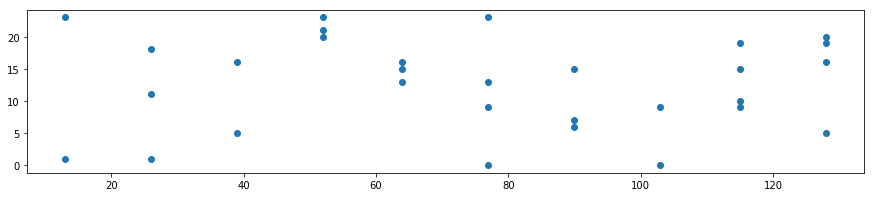

In [23]:
for notes_, label_, spectrogram_ in zip(glob_notes, glob_label, glob_spectrogram):
    print(np.shape(label))
    print(np.shape(np.zeros((20,24))))
    lstm_label = np.append(np.zeros((20,24)),label,axis=0)
    print(np.shape(lstm_label))
    
    lstm_inputs = np.array(list(zip([lstm_label[i:-20+i] for i in range(20)])))
    lstm_inputs = np.swapaxes(lstm_inputs,0,2)
    print(np.shape(lstm_inputs))
    
    plt.figure(figsize=(15,3))
    ground_truth = []
    for i,lstm_input in enumerate(lstm_inputs):
        for time_slice in lstm_input[:,-1,:]:
            for j,note in enumerate(time_slice):
#                 print(note)
                if note != 0:
                    ground_truth.append((i,j))
    
    ground_truth = np.transpose(ground_truth)
    plt.scatter(ground_truth[:][0],ground_truth[:][1])
plt.show()

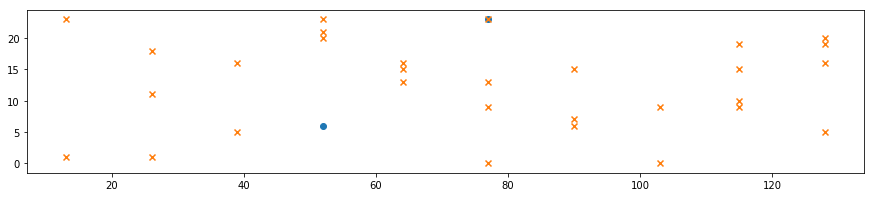

In [24]:
plt.figure(figsize=(15,3))
lstm_memory = np.zeros((1,20,24))
predicted_score = []

for i,(cnn_input, lstm_input) in enumerate(list(zip(cnn_inputs, lstm_inputs))):
    
#     print(np.shape(cnn_input))
#     print(np.shape(lstm_input))
#     give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))
#     print(lstm_input[-1,-1])
#     print(result)
    result = give_prediction(classifier, lstm_memory, cnn_input.reshape((1,108,108,1)))
    lstm_memory[0,:-1] = np.copy(lstm_memory[0,1:])
    lstm_memory[0,-1] = np.copy(result)
    for j, note in enumerate(result[0]):
        if note != 0:
            predicted_score.append([i,j])

predicted_score = np.transpose(predicted_score)
plt.scatter(predicted_score[0], predicted_score[1], marker='o')            
plt.scatter(ground_truth[0], ground_truth[1], marker='x')
plt.show()